<a href="https://colab.research.google.com/github/shreya0505/ComputerVisionTutorial/blob/master/ImageScanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
import os
directory = '/content/drive/My Drive/Dataset/images'
files = list()
for filename in os.listdir(directory):
  file_path = os.path.join(directory, filename)
  files.append(file_path)
print(files)
  

['/content/drive/My Drive/Dataset/images/page.jpg', '/content/drive/My Drive/Dataset/images/receipt.jpg', '/content/drive/My Drive/Dataset/images/166-receipt.jpg', '/content/drive/My Drive/Dataset/images/340px-ReceiptSwiss.jpg']


(500, 375, 3)


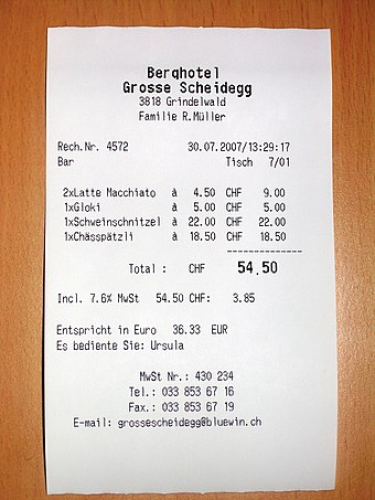


STEP 1: Canny Edge detection



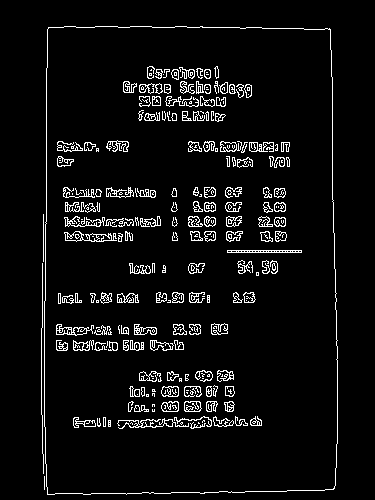

(500, 375)
(500, 375, 3)


In [174]:
import torch
import imutils
import cv2
from google.colab.patches import cv2_imshow

#Resize
image = cv2.imread(files[3])
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
print(image.shape)
cv2_imshow(image)

#Canny Edge Detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
edged = cv2.Canny(gray, 75, 200)
print("\nSTEP 1: Canny Edge detection\n")
cv2_imshow(edged)
print(edged.shape)
print(image.shape)


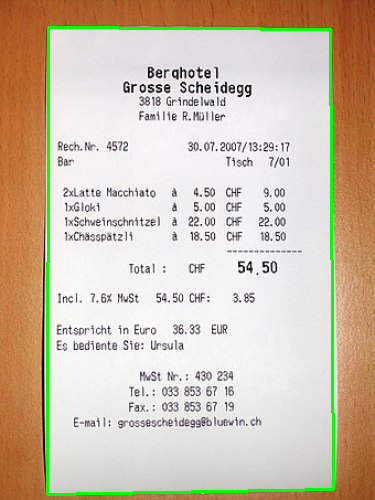

[[[ 48  27]]

 [[ 47 494]]

 [[333 489]]

 [[330  29]]]


In [175]:
#contours
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
for c in cnts:
	# approximate the contour
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  if len(approx) == 4:
    screenCnt = approx
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    break
cv2_imshow(image)
print(screenCnt)




In [0]:

import numpy as np
import cv2
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect


In [0]:

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

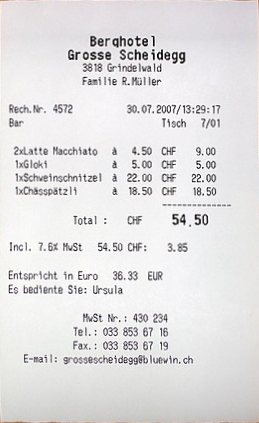

In [177]:
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
cv2_imshow(warped)

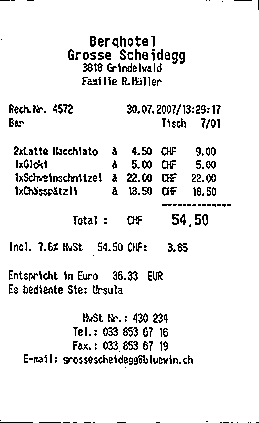

In [178]:
from skimage.filters import threshold_local

cropped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

block_size = 11
adaptive_thresh = threshold_local(cropped_gray, block_size, offset=10, method = "gaussian")
binary_adaptive =  (cropped_gray > adaptive_thresh).astype("uint8") * 255

cv2_imshow(binary_adaptive)